
******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



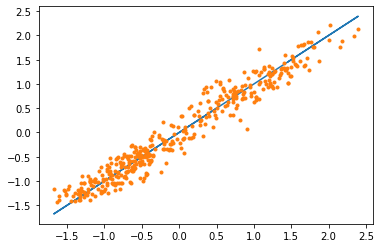

In [1]:
from casadi import *
import numpy as np
import pandas as pd
from numpy.linalg import norm
import sADMM
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

raw = pd.read_csv("CCPP.csv") 
# scale data to have zero mean and std = 1
scaler = StandardScaler()
data = scaler.fit_transform(raw)

x = data[0:400,0:4]
#x['bias'] = np.ones(x.shape[0])
#x = x.to_numpy()

y = data[0:400,4]
#y = y.to_numpy()
y = y.reshape(-1,1)


nu = 4                     # no. of inputs
ny = 1                     # no. of outputs
nn = 5                     # no. of neurons 
nw =  nu*nn+nn+ny*nn+ny    # no. of parameters

# Solve centralized optimization
solver,nlp = sADMM.MLP_regression(x,y,nn)
Primal,Dual,f = sADMM.solvenlp(solver,nlp)
w_opt = Primal.full()

# Prediction
y_pred0 = sADMM.MLP(x,w_opt,4,5,1)
plt.plot(y,y)
plt.plot(y,y_pred0.full().reshape(-1,1),'.')

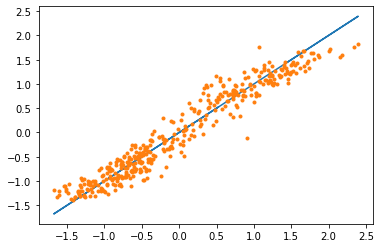

In [2]:

N = 4
nData,ny = y.shape
nblock = round(nData/N)

# Split data into N data chunks
x1 = x[0*nblock:1*nblock,:]
x2 = x[1*nblock:2*nblock,:]
x3 = x[2*nblock:3*nblock,:] 
x4 = x[3*nblock:4*nblock,:]

y1 = y[0*nblock:1*nblock,:] 
y2 = y[1*nblock:2*nblock,:]
y3 = y[2*nblock:3*nblock,:] 
y4 = y[3*nblock:4*nblock,:]

rho = 100 # penalty term in the Augmented Lagrangian


solver0,nlp0 = sADMM.consensus_reg_nn(nw,N,rho)

solver1,nlp1 = sADMM.consensus_subproblem_nn(x1,y1,nn,rho)
solver2,nlp2 = sADMM.consensus_subproblem_nn(x2,y2,nn,rho)
solver3,nlp3 = sADMM.consensus_subproblem_nn(x3,y3,nn,rho)
solver4,nlp4 = sADMM.consensus_subproblem_nn(x4,y4,nn,rho)

solvers = [solver1,solver2,solver3,solver4]
nlps = [nlp1,nlp2,nlp3,nlp4]

x0_opt = w_opt*0.0    # initial guess for x0
lam = np.ones(nw)      # initial guess for lambda_i
Lam = []
for i in range(0,len(solvers)):
    Lam.append(lam)  # Lam = [lambda_1,...lambda_N]
    
x0_opt,x_opt = sADMM.ADMM_consensus(solvers,nlps,solver0,nlp0,x0_opt,Lam,rho,tol=0.0002,MaxIter=30)

# Prediction
y_pred0 = sADMM.MLP(x,x0_opt.full(),4,5,1)
plt.plot(y,y)
plt.plot(y,y_pred0.full().reshape(-1,1),'.')

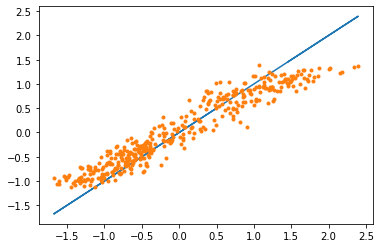

In [4]:
x0_opt = w_opt*0    # initial guess for x0
lam = np.ones(nw)      # initial guess for lambda_i
Lam = []
for i in range(0,len(solvers)):
    Lam.append(lam)  # Lam = [lambda_1,...lambda_N]
    
x0_opt,x_opt = sADMM.sADMM_consensus(solvers,nlps,solver0,nlp0,x0_opt,Lam,rho,tol=0.0002,MaxIter=30)

# Prediction
y_pred0 = sADMM.MLP(x,x0_opt.full(),4,5,1)
plt.plot(y,y)
plt.plot(y,y_pred0.full().reshape(-1,1),'.')

In [3]:
print(x_opt[0])
print(x_opt[1])
print(x_opt[2])
print(x0_opt)
print(Primal)

[-0.789308, -0.136754, 1.18095, 0.957264, 1.58151, -0.430304, 0.426648, 0.0996513, -0.138414, -0.594898, 0.2925, 0.899562, 0.536563, 1.32486, -0.326756, -0.0308884, 0.765757, 0.383687, 0.477924, -0.217136, -0.037275, -1.10209, 0.616098, 0.355965, 1.00299, 2.08323, -0.487281, -1.19209, 0.300769, -0.9921, 0.357281]
[-0.789271, -0.136788, 1.18087, 0.957277, 1.58151, -0.430372, 0.426642, 0.0996619, -0.138422, -0.594888, 0.292493, 0.899574, 0.536617, 1.32485, -0.326771, -0.0307953, 0.765751, 0.383658, 0.477921, -0.217181, -0.0372543, -1.10209, 0.616089, 0.355972, 1.00297, 2.08331, -0.487245, -1.19201, 0.300867, -0.991874, 0.357482]
[-0.7894, -0.136708, 1.18104, 0.957225, 1.58155, -0.430406, 0.426692, 0.0997338, -0.138451, -0.594863, 0.29263, 0.899531, 0.536472, 1.32488, -0.326839, -0.0307001, 0.765709, 0.383588, 0.477949, -0.217227, -0.0371061, -1.10215, 0.615986, 0.355997, 1.0029, 2.08372, -0.487003, -1.19183, 0.301137, -0.991864, 0.357868]
[-0.789377, -0.136738, 1.18098, 0.957248, 1.58156